# ✈**Mount Drive dan Cek GPU Colab**

In [1]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
print("GPU Available: ", tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Mounted at /content/drive
GPU Available:  False


# ✈**Hitung File yang Digunakan**

In [2]:
import os

train_folder = "/content/drive/MyDrive/DatasetSplit90Clahe/train"
validation_folder = "/content/drive/MyDrive/DatasetSplit90Clahe/validation"
test_folder = "/content/drive/MyDrive/DatasetSplit90Clahe/test"

categories = ["Mass", "Nodule", "Normal", "Pneumonia", "Tuberculosis"]

print("TRAIN")
for category in categories:
    category_folder = os.path.join(train_folder, category)
    file_count = len(os.listdir(category_folder))
    print(f"Jumlah file pada folder {category}: {file_count}")
print("VALIDATION")
for category in categories:
    category_folder = os.path.join(validation_folder, category)
    file_count = len(os.listdir(category_folder))
    print(f"Jumlah file pada folder {category}: {file_count}")
print("TEST")
for category in categories:
    category_folder = os.path.join(test_folder, category)
    file_count = len(os.listdir(category_folder))
    print(f"Jumlah file pada folder {category}: {file_count}")

TRAIN
Jumlah file pada folder Mass: 1800
Jumlah file pada folder Nodule: 1798
Jumlah file pada folder Normal: 1800
Jumlah file pada folder Pneumonia: 1800
Jumlah file pada folder Tuberculosis: 1796
VALIDATION
Jumlah file pada folder Mass: 100
Jumlah file pada folder Nodule: 100
Jumlah file pada folder Normal: 100
Jumlah file pada folder Pneumonia: 100
Jumlah file pada folder Tuberculosis: 100
TEST
Jumlah file pada folder Mass: 93
Jumlah file pada folder Nodule: 100
Jumlah file pada folder Normal: 100
Jumlah file pada folder Pneumonia: 100
Jumlah file pada folder Tuberculosis: 100


In [3]:
train_dir = '/content/drive/MyDrive/DatasetSplit90Clahe/train'
val_dir = '/content/drive/MyDrive/DatasetSplit90Clahe/validation'
test_dir = '/content/drive/MyDrive/DatasetSplit90Clahe/test'

# ✈**Preprocessing dan Setting Layer**

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model


num_classes = len(categories)
image_size = (224, 224)
batch_size = 32


train_datagen = ImageDataGenerator(
    # rescale=1./255,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
    )

val_datagen = ImageDataGenerator(
    # rescale=1./255
    )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical')

# Test Generator
test_datagen = ImageDataGenerator()

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Membuat model MobileNet (ditambah channel RGB, karena gambar sebelumnya grayscale)
base_model = MobileNet(input_shape=image_size + (3,), include_top=False, weights='imagenet')

# Menambahkan lapisan global pooling dan lapisan output
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Menggabungkan model
model = Model(inputs=base_model.input, outputs=predictions)

# Membekukan lapisan awal (pretrained) agar tidak terupdate saat melatih model (transfer learning)
for layer in base_model.layers:
    layer.trainable = False



Found 8994 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Found 493 images belonging to 5 classes.
17225924/17225924 [==============================] - 0s 0us/step


# ✈**Train Model**

In [5]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# Buat objek callback EarlyStopping

epochs = 50
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = val_generator.n // val_generator.batch_size
# lr = default


early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

# Mengkompilasi model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=[early_stop])

# Menyimpan model
model.save('/content/drive/MyDrive/MobileNet_90_Adam_model.h5')

Epoch 1/50
281/281 [==============================] - 1526s 5s/step - loss: 0.7432 - accuracy: 0.6773 - val_loss: 0.6288 - val_accuracy: 0.7000
Epoch 2/50
281/281 [==============================] - 478s 2s/step - loss: 0.5591 - accuracy: 0.7343 - val_loss: 0.5403 - val_accuracy: 0.7667
Epoch 3/50
281/281 [==============================] - 497s 2s/step - loss: 0.4975 - accuracy: 0.7608 - val_loss: 0.5559 - val_accuracy: 0.7396
Epoch 4/50
281/281 [==============================] - 466s 2s/step - loss: 0.4770 - accuracy: 0.7694 - val_loss: 0.4844 - val_accuracy: 0.7729
Epoch 5/50
281/281 [==============================] - 474s 2s/step - loss: 0.4353 - accuracy: 0.7880 - val_loss: 0.5438 - val_accuracy: 0.7750
Epoch 6/50
281/281 [==============================] - 484s 2s/step - loss: 0.4216 - accuracy: 0.7965 - val_loss: 0.4971 - val_accuracy: 0.7708
Epoch 7/50
281/281 [==============================] - 481s 2s/step - loss: 0.4089 - accuracy: 0.8028 - val_loss: 0.5016 - val_accuracy: 0.764

# ✈**Test dan Grafik**

16/16 [==============================] - 96s 6s/step
              precision    recall  f1-score   support

        Mass    0.66667   0.45161   0.53846        93
      Nodule    0.58400   0.73000   0.64889       100
      Normal    0.81818   0.90000   0.85714       100
   Pneumonia    0.95876   0.93000   0.94416       100
Tuberculosis    0.98980   0.97000   0.97980       100

    accuracy                        0.80122       493
   macro avg    0.80348   0.79632   0.79369       493
weighted avg    0.80542   0.80122   0.79731       493

[[42 47  3  1  0]
 [19 73  8  0  0]
 [ 2  4 90  3  1]
 [ 0  1  6 93  0]
 [ 0  0  3  0 97]]
1/1 [==============================] - 2s 2s/step


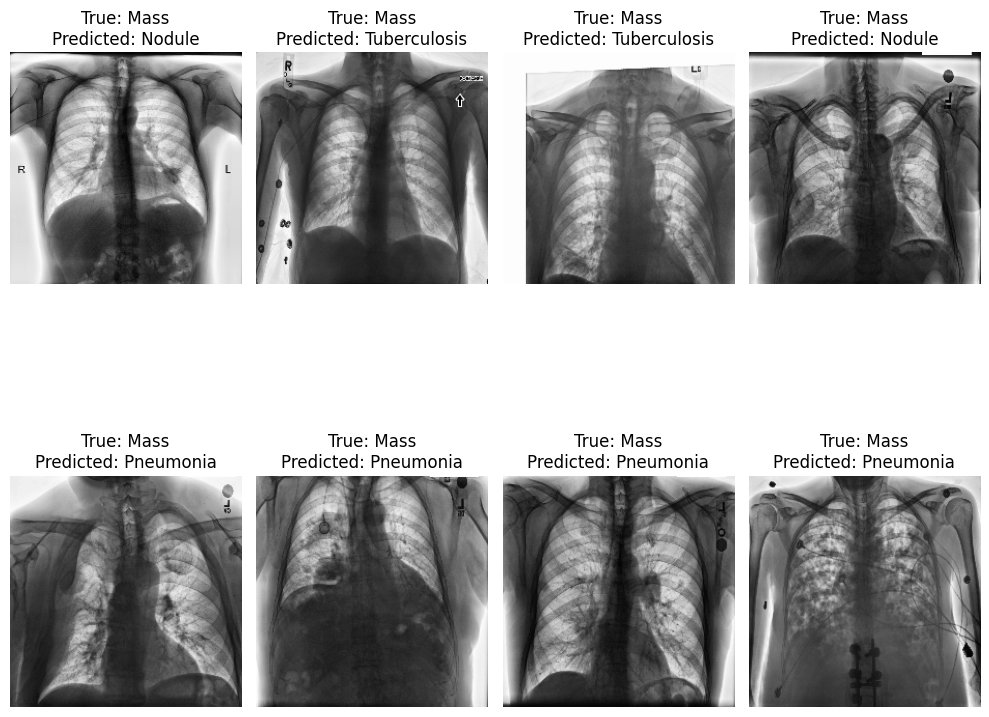

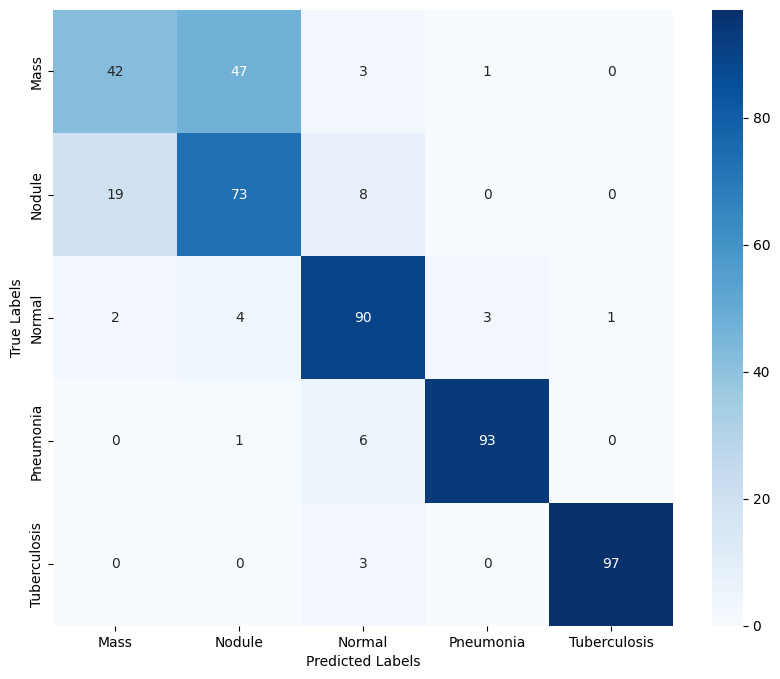

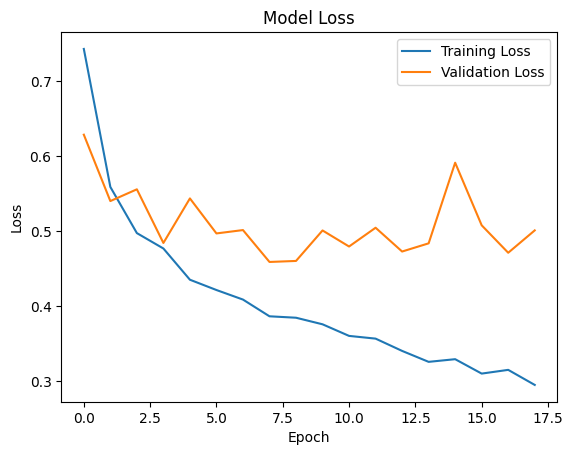

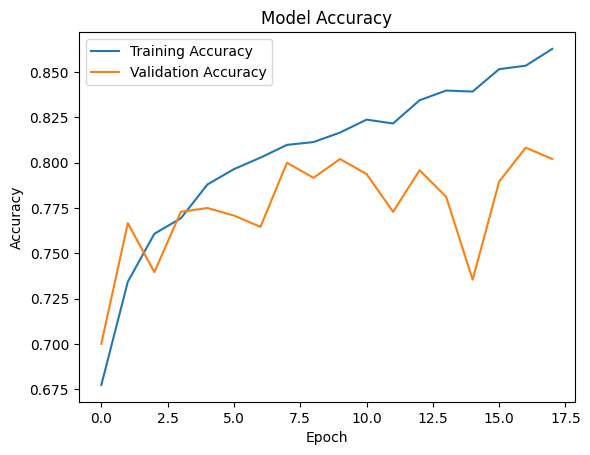

In [6]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix


# Prediksi data test
y_pred = model.predict(test_generator)

# Prediksi berdasaarkan class/label
y_pred_labels = np.argmax(y_pred, axis=1)
class_names = ["Mass", "Nodule", "Normal", "Pneumonia", "Tuberculosis"]

# get true labels from the generator
y_true = test_generator.classes

# Confusion Matrix
report = classification_report(y_true, y_pred_labels, target_names=class_names, digits=5)
conf_mat = confusion_matrix(y_true, y_pred_labels)

print(report)
print(conf_mat)

# Load batch data
batch_images, batch_labels = next(test_generator)

# Normalisasi kembali gambar ke rentang 0-255
batch_images = (batch_images * 255).astype(np.uint8)

# Predict labels/class dengan model
predicted_labels = model.predict(batch_images)

# Daftar class
class_names = list(train_generator.class_indices.keys())

# Membuat plot
grid_size = (2, 4)
fig, ax = plt.subplots(nrows=grid_size[0], ncols=grid_size[1], figsize=(10, 10))
for i , axi in enumerate(ax.flat):
    # Plot image
    axi.imshow(batch_images[i])
    axi.set_title(f"True: {class_names[np.argmax(batch_labels[i])]}\nPredicted: {class_names[np.argmax(predicted_labels[i])]}")
    axi.axis("off")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', 
            xticklabels=["Mass", "Nodule", "Normal", "Pneumonia", "Tuberculosis"], 
            yticklabels=["Mass", "Nodule", "Normal", "Pneumonia", "Tuberculosis"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Mengambil nilai loss dan akurasi dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Membuat grafik loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Membuat grafik akurasi
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()